In [ ]:
# variable for whether running on colab or not
running_on_colab = False

In [ ]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [4]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7



First training image NDVI band:


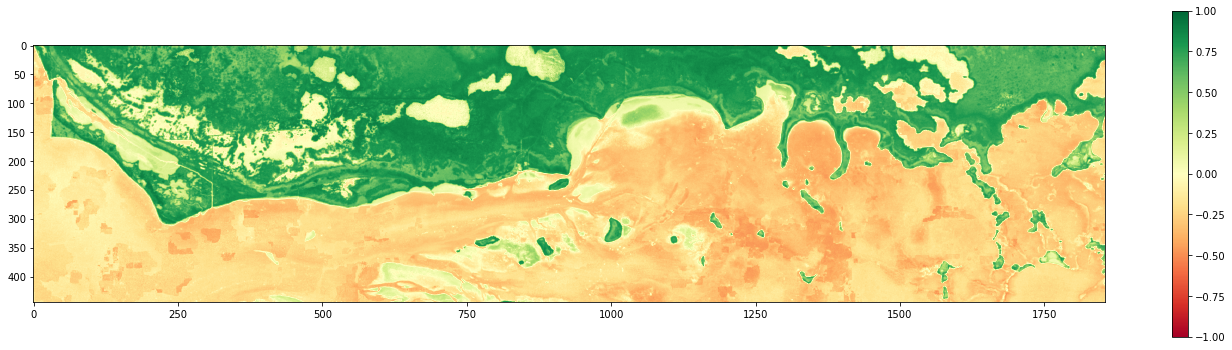


First training image mangroves from labels: 


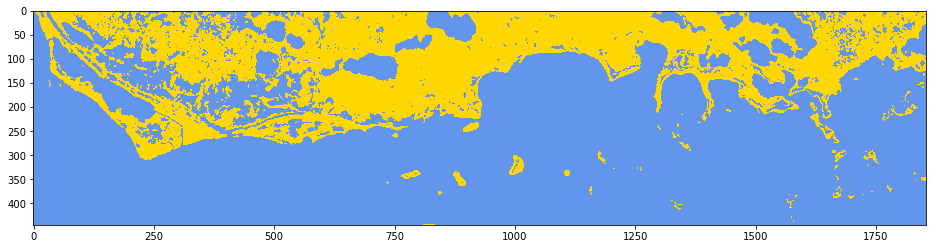

Using training data of length:  3301010
Class 0: 2419556 Class 1: 881454
Class 0:  73.3% Class 1:  26.7%


In [5]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "Florida_1_2000.tif")
# training_images.append(image_base_path + "Florida_3_2000.tif")
# training_images.append(image_base_path + "Florida_4_2000.tif")
training_images.append(image_base_path + "Florida_5_2000.tif")
training_images.append(image_base_path + "Florida_6_2000.tif")
training_images.append(image_base_path + "Florida_7_2000.tif")

# training_images.append(image_base_path + "Brazil_2_2000.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)

In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(1980606, 1, 7)
(1320404, 1, 7)


In [7]:
# normalize bands
xTrain = diu.normalizeUInt16Band(xTrain)
xTest = diu.normalizeUInt16Band(xTest)

In [8]:
# Define the parameters of the model
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(1, nBands)),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 14)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 30        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)

Epoch 1/3
43326/43326 [==============================] - 75s 2ms/step - loss: 0.2189 - accuracy: 0.9078 - val_loss: 0.1590 - val_accuracy: 0.9386
Epoch 2/3
43326/43326 [==============================] - 68s 2ms/step - loss: 0.1602 - accuracy: 0.9383 - val_loss: 0.1566 - val_accuracy: 0.9399
Epoch 3/3
43326/43326 [==============================] - 62s 1ms/step - loss: 0.1573 - accuracy: 0.9392 - val_loss: 0.1549 - val_accuracy: 0.9398


In [10]:
# print(history.history)

# could make some plots of the metrics/convergance - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

Confusion matrix:
 [[924015  43807]
 [ 35416 317166]]

P-Score: 0.879, R-Score: 0.900
Accuracy: 0.940
f1: 0.889
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    967822
         1.0       0.88      0.90      0.89    352582

    accuracy                           0.94   1320404
   macro avg       0.92      0.93      0.92   1320404
weighted avg       0.94      0.94      0.94   1320404



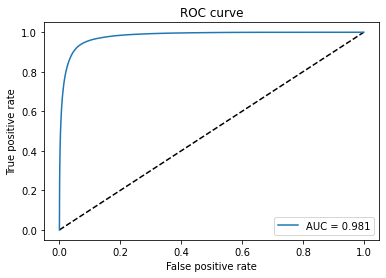

0.980785667121264

In [11]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)



Predicting for image: ../SatelliteImages/Florida_3_2000.tif

Image 2000 NDVI band:


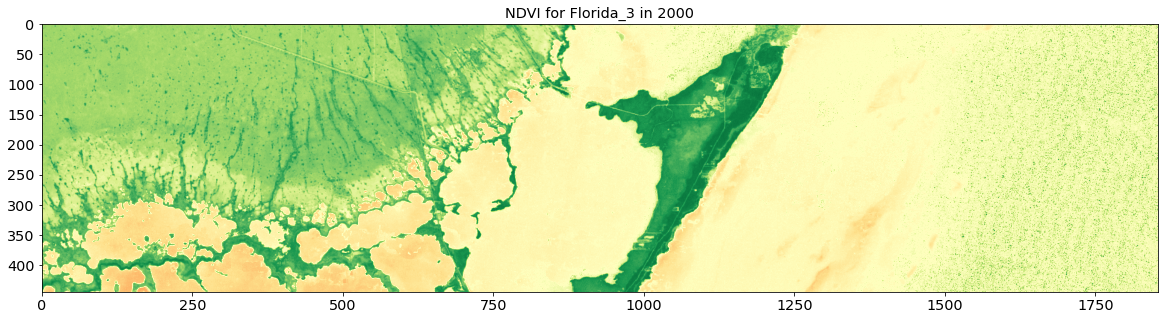


Label mangroves from 2000 data:


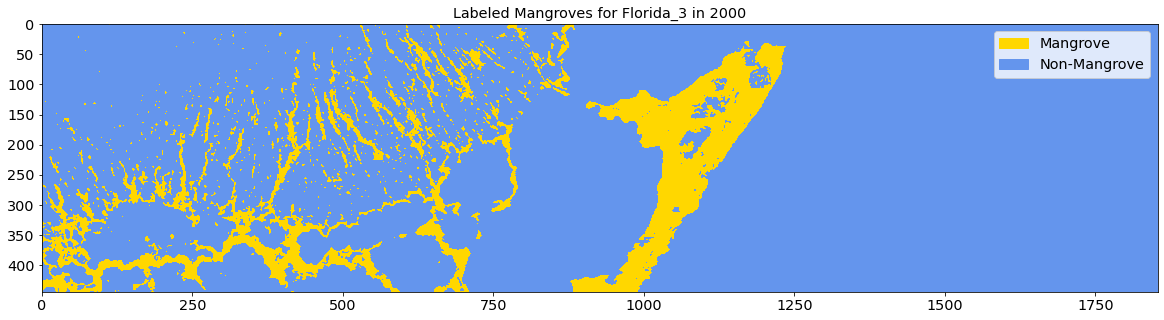


Predicted mangroves:


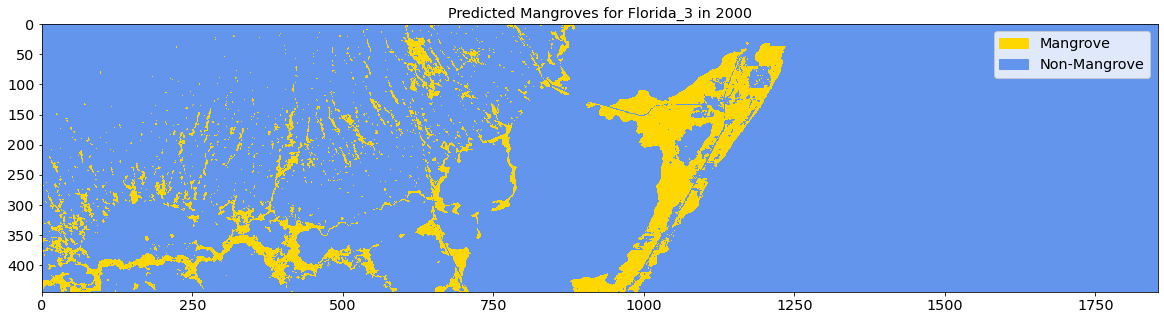


Difference between predicted and labeled mangroves from the year 2000:


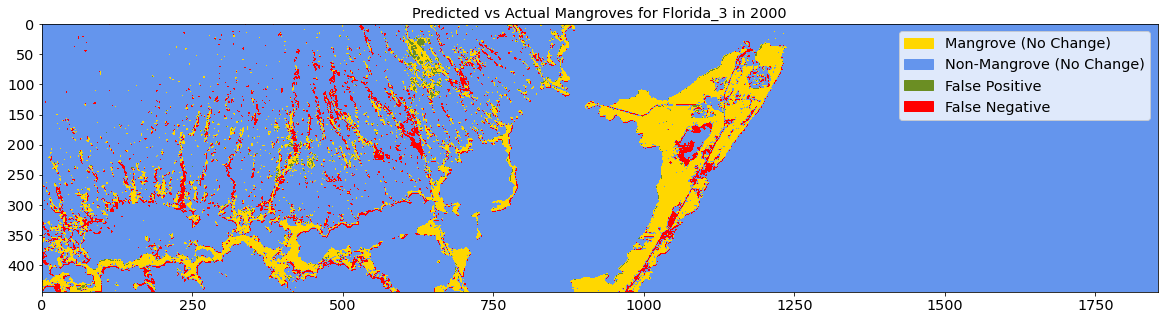

Confusion matrix:
 [[721029   6812]
 [ 27168  70021]]

P-Score: 0.911, R-Score: 0.720
Accuracy: 0.959
f1: 0.805
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    727841
           1       0.91      0.72      0.80     97189

    accuracy                           0.96    825030
   macro avg       0.94      0.86      0.89    825030
weighted avg       0.96      0.96      0.96    825030



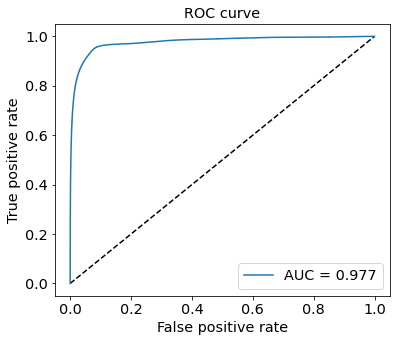

In [32]:
## apply model to new images
diu.predictOnImage(model, image_base_path + "Florida_3_2000.tif")
# diu.predictOnImage(model, image_base_path + "Florida_4_2000.tif")

# diu.predictOnImage(model, image_base_path + "Florida_6_2000.tif")
# diu.predictOnImage(model, image_base_path + "Florida_7_2000.tif")


# diu.predictOnImage(model, image_base_path + "Florida_1_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_3_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_4_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_5_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_6_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_7_2020.tif")



# diu.predictOnImage(model, image_base_path + "Brazil_1_2000.tif")


In [13]:
print('not now timeout!')

not now timeout!
